In [195]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px


# Define paths


In [196]:
df = pd.read_excel("/Users/muhammetozturk/Downloads/v1/full_data.xlsx")

In [197]:
# Convert reaction time and accuracy to numeric and filter invalid values
df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
df['correct'] = df['correct'].astype(bool)
df.dropna(subset=['rt'], inplace=True)


In [198]:
# this will assign each unique ID a code 0,1,2… in the order they first appear
codes, uniques = pd.factorize(df['Participant_ID'])

# build your label: 1‑based subject numbers with “subj#” prefix
df['Participant'] = 'subj#' + (codes + 1).astype(str)
df.drop(columns=['participant'], inplace=True)
df

,trial,emotional_class,category,response,correct,rt,gender,age,Participant_ID,Age,Participant
0,0,Neutral,Outdoors,o,True,0.799707,Male,23,a956805e,23,subj#1
1,1,Negative,Outdoors,o,True,0.355931,Male,23,a956805e,23,subj#1
2,2,Negative,Outdoors,i,False,0.467380,Male,23,a956805e,23,subj#1
3,3,Positive,Outdoors,o,True,0.316443,Male,23,a956805e,23,subj#1
4,4,Negative,Indoors,o,False,0.385921,Male,23,a956805e,23,subj#1
...,...,...,...,...,...,...,...,...,...,...,...
12955,175,Neutral,Outdoors,o,True,0.359819,Female,22,9100c82a,22,subj#72
12956,176,Neutral,Indoors,i,True,0.493462,Female,22,9100c82a,22,subj#72
12957,177,Neutral,Outdoors,o,True,0.274381,Female,22,9100c82a,22,subj#72
12958,178,Negative,Indoors,i,True,0.312394,Female,22,9100c82a,22,subj#72


In [201]:
upper_limit = df['rt'].mean() + 3 * df['rt'].std()
lower_limit = df['rt'].mean() - 3 * df['rt'].std()
df['Outlier'] = (df['rt'] > upper_limit) | (df['rt'] < lower_limit)



In [202]:
demo_tbl = (
    df[['Participant','gender','age']]
      .drop_duplicates()
      .groupby('gender')
      .agg(
         N=('Participant','nunique'),
         age_mean=('age','mean'),
      )
      .reset_index()
)
demo_tbl


,gender,N,age_mean
0,Female,24,22.083333
1,Male,48,24.166667


Correlation age ↔ mean RT: r = 0.17, p = 0.157


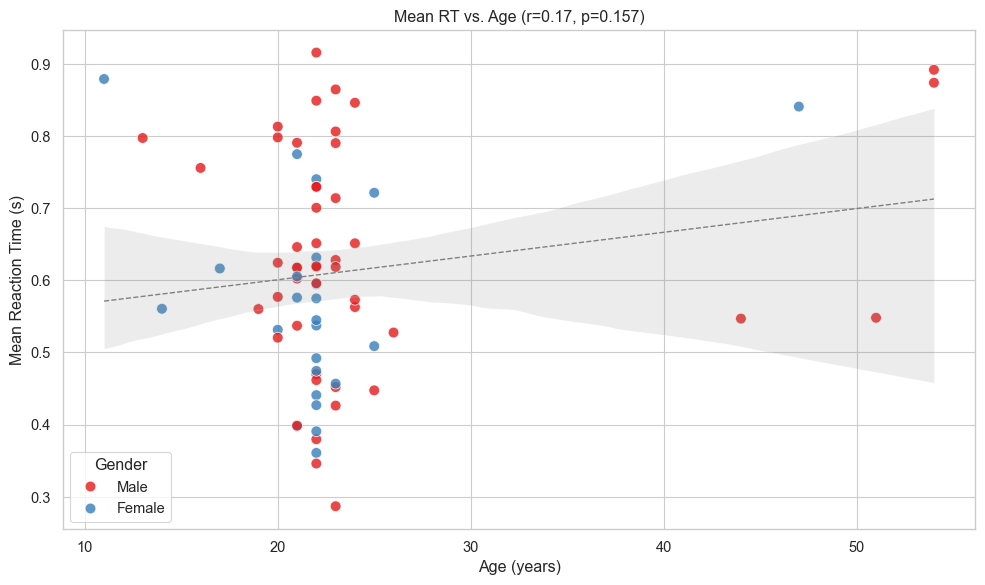

In [203]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Aggregate to one RT per participant
subj_rt = (
    df
    .groupby(['Participant','age','gender'])['rt']
    .mean()
    .reset_index(name='rt_mean')
)

# 2. Compute and print the Pearson r
r, p = pearsonr(subj_rt['age'], subj_rt['rt_mean'])
print(f"Correlation age ↔ mean RT: r = {r:.2f}, p = {p:.3f}")

# 3. Scatter + regression by gender
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=subj_rt, x='age', y='rt_mean',
    hue='gender', palette='Set1', s=60, alpha=0.8
)
sns.regplot(
    data=subj_rt, x='age', y='rt_mean',
    scatter=False, color='gray', ci=95, line_kws={'lw':1, 'ls':'--'}
)

plt.xlabel('Age (years)')
plt.ylabel('Mean Reaction Time (s)')
plt.title(f'Mean RT vs. Age (r={r:.2f}, p={p:.3f})')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


In [204]:
summary = df.groupby(['emotional_class', 'category']).agg(
    mean_rt=('rt', 'mean'),
    std_rt=('rt', 'std'),
    mean_acc=('correct', 'mean'),
    std_acc=('correct', 'std'),
    n=('Participant_ID', 'nunique')  # Include sample size per group
).reset_index()

# Round decimals for cleaner display
summary = summary.round({
    'mean_rt': 3,
    'std_rt': 3,
    'mean_acc': 3,
    'std_acc': 3
})

# Rename columns for clarity
summary.columns = [
    'Emotional Class', 
    'Category', 
    'Mean RT (s)', 
    'SD RT (s)', 
    'Mean Accuracy', 
    'SD Accuracy',
    'N'
]

# Style the table for better readability
styled_table = (
    summary.style
    .format({
        'Mean RT (s)': '{:.3f}',
        'SD RT (s)': '{:.3f}',
        'Mean Accuracy': '{:.2f}',
        'SD Accuracy': '{:.2f}'
    })
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f7f7f7'), ('font-weight', 'bold')]
    }])
    .hide(axis='index')  # Remove row numbers
)

display(styled_table)

Emotional Class,Category,Mean RT (s),SD RT (s),Mean Accuracy,SD Accuracy,N
Negative,Indoors,0.636,0.249,0.71,0.46,72
Negative,Outdoors,0.573,0.249,0.89,0.31,72
Neutral,Indoors,0.627,0.242,0.69,0.46,72
Neutral,Outdoors,0.581,0.242,0.89,0.31,72
Positive,Indoors,0.648,0.249,0.74,0.44,72
Positive,Outdoors,0.587,0.243,0.89,0.31,72


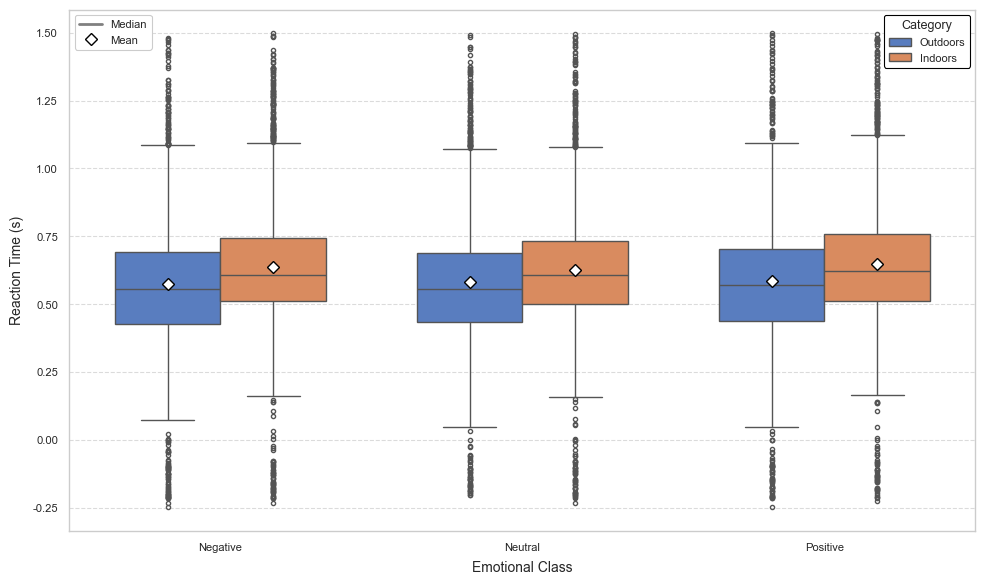

In [205]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

# 1. Journal‐style fonts
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['axes.unicode_minus'] = False

# 2. Seaborn theme + context for paper
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2, palette="pastel")

# 3. Load and prepare data
df['Accuracy'] = df['correct'].astype(int)

# 4. Plot settings
class_order      = ['Negative', 'Neutral', 'Positive']
category_offsets = {'Indoors': -0.2, 'Outdoors': 0.2}

plt.figure(figsize=(10, 6))  # single‐column width in inches
ax = sns.boxplot(
    data=df,
    x='emotional_class',
    y='rt',
    hue='category',
    order=class_order,
    palette='muted',
    linewidth=1,
    width=0.7,
    fliersize=3,
    showmeans=True,
    meanprops={
        'marker': 'D',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 6
    }
)

# 5. Compute & annotate stats
stats_median = (
    df.groupby(['emotional_class','category'])['rt']
      .median().reset_index()
)
stats_mean = (
    df.groupby(['emotional_class','category'])['rt']
      .mean().reset_index()
)


# 6. Legends: Category + stat proxies
handles, labels = ax.get_legend_handles_labels()
cat_leg = ax.legend(
    handles, labels,
    title='Category',
    title_fontsize=9, fontsize=8,
    loc='upper right', framealpha=1, edgecolor='black'
)

median_line = Line2D([0],[0], color='gray', lw=2, label='Median')
mean_marker = Line2D([0],[0], marker='D', color='w',
                     markeredgecolor='black', markersize=6, lw=0, label='Mean')
ax.add_artist(cat_leg)
ax.legend(
    handles=[median_line, mean_marker],
    labels=['Median','Mean'],
    loc='upper left', framealpha=1, fontsize=8, title_fontsize=9
)

# 7. Labels, title, grid, layout
ax.set_xlabel('Emotional Class', fontsize=10, labelpad=6)
ax.set_ylabel('Reaction Time (s)', fontsize=10, labelpad=6)
ax.set_title('', pad=10)  # remove or leave blank for panel figure
ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


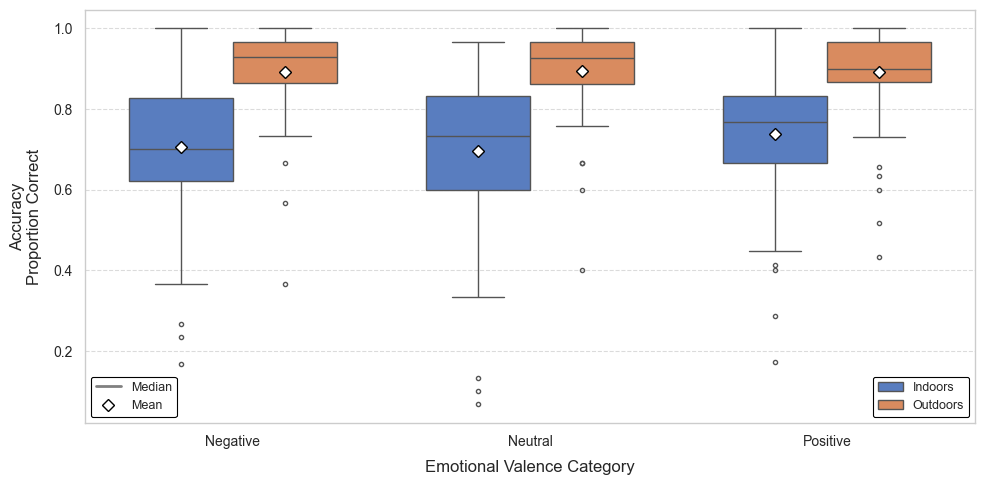

In [206]:
from matplotlib import rcParams
from matplotlib.lines import Line2D

# 1. Load and prepare raw data

df['Accuracy'] = df['correct'].astype(int)

# 2. Aggregate to get one accuracy per participant × condition
accuracy_data = (
    df.groupby(['Participant', 'emotional_class', 'category'])['Accuracy']
      .mean()
      .reset_index()
)

# 3. Journal-style fonts and theme
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# 4. Plot settings
class_order      = ['Negative', 'Neutral', 'Positive']
category_offsets = {'Indoors': -0.2, 'Outdoors': 0.2}

# 5. Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# 6. Boxplot of accuracy
sns.boxplot(
    data=accuracy_data,
    x='emotional_class',
    y='Accuracy',
    hue='category',
    palette='muted',
    linewidth=1,
    width=0.7,
    fliersize=3,
    showmeans=True,
    meanprops={
        'marker': 'D',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 6
    }
)

# 7. Category legend
handles, labels = ax.get_legend_handles_labels()
cat_legend = ax.legend(
    handles[:2], ['Indoors', 'Outdoors'],
    fontsize=9,
    loc='lower right',
    framealpha=1,
    edgecolor='black'
)

# 8. Stats legend proxies
median_line = Line2D([0], [0], color='gray', lw=2, label='Median')
mean_marker = Line2D([0], [0], marker='D', color='w',
                     markeredgecolor='black', markersize=6, lw=0, label='Mean')

stat_legend = ax.legend(
    handles=[median_line, mean_marker],
    labels=['Median', 'Mean'],
    fontsize=9,
    loc='lower left',
    framealpha=1,
    edgecolor='black'
)

# 9. Add the category legend back
ax.add_artist(cat_legend)

# 10. Labels, title, grid
ax.set_xlabel('Emotional Valence Category', fontsize=12, labelpad=8)
ax.set_ylabel('Accuracy\nProportion Correct', fontsize=12, labelpad=8)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [207]:
# ANOVA for Reaction Time
model_rt = ols('rt ~ C(emotional_class) + C(category) + C(emotional_class):C(category)', data=df).fit()
anova_rt = sm.stats.anova_lm(model_rt, typ=2)
display("ANOVA Results for Reaction Time:\n", anova_rt)



'ANOVA Results for Reaction Time:\n'

,sum_sq,df,F,PR(>F)
C(emotional_class),0.465626,2.0,3.855901,2.117935e-02
C(category),10.240914,1.0,169.612428,1.588354e-38
C(emotional_class):C(category),0.174805,2.0,1.447579,2.351778e-01
Residual,765.295256,12675.0,NaN,NaN


In [208]:
# ANOVA for Accuracy
model_acc = ols('Accuracy ~ C(emotional_class) + C(category) + C(emotional_class):C(category)', data=accuracy_data).fit()
anova_acc = sm.stats.anova_lm(model_acc, typ=2)
display("ANOVA Results for Accuracy:\n", anova_acc)



'ANOVA Results for Accuracy:\n'

,sum_sq,df,F,PR(>F)
C(emotional_class),0.030066,2.0,0.746469,4.746562e-01
C(category),3.460872,1.0,171.849388,3.201959e-33
C(emotional_class):C(category),0.040117,2.0,0.995993,3.702149e-01
Residual,8.579207,426.0,NaN,NaN


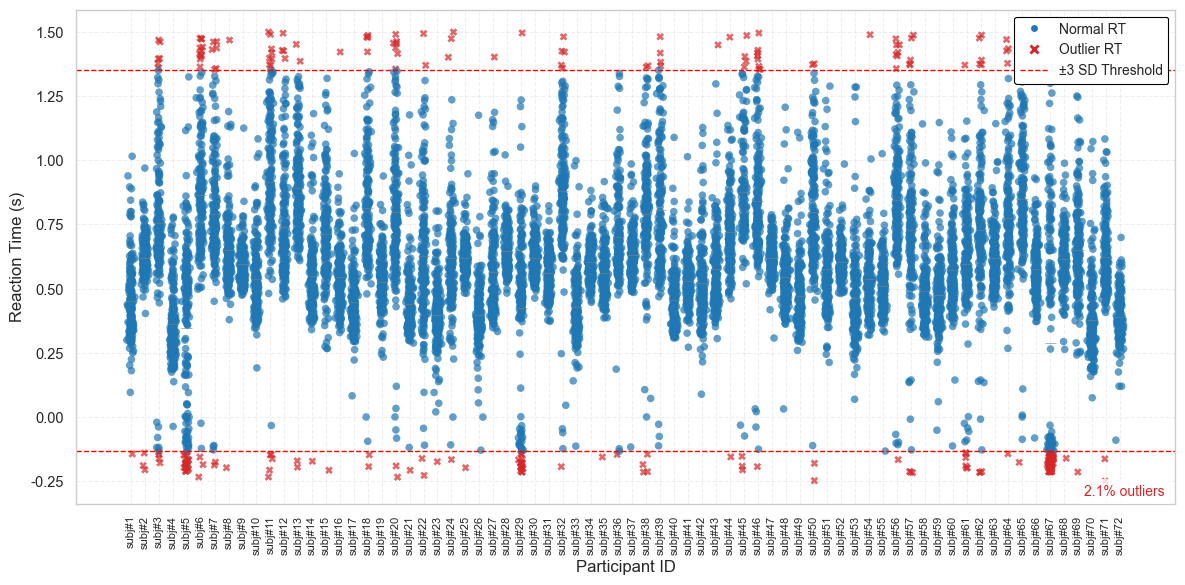

In [216]:
mean_rt     = df['rt'].mean()
std_rt      = df['rt'].std()
upper_limit = mean_rt + 3 * std_rt
lower_limit = mean_rt - 3 * std_rt
df['Outlier'] = (df['rt'] > upper_limit) | (df['rt'] < lower_limit)

# 3. Journal‐style fonts & theme
rcParams['font.family']     = 'serif'
rcParams['font.serif']      = ['Times New Roman']
rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# 4. Compute jittered x‐positions for each participant
codes, participants = pd.factorize(df['Participant'])
df['jittered_x'] = codes + np.random.normal(0, 0.1, size=len(df))

# 5. Prepare figure
fig, ax = plt.subplots(figsize=(12, 6))

# 6. Scatter plot of RTs, colored by outlier status
sns.scatterplot(
    data=df,
    x='jittered_x',
    y='rt',
    hue='Outlier',
    style='Outlier',
    palette={False: '#1f77b4', True: '#d62728'},
    markers={False: 'o', True: 'X'},
    alpha=0.7,
    s=30,
    edgecolor='none',
    ax=ax
)

# 7. Plot each participant’s mean RT
mean_rts = df.groupby('Participant')['rt'].mean().reindex(participants).values
for i, m in enumerate(mean_rts):
    ax.hlines(m, i - 0.4, i + 0.4, color='gray', linewidth=0.7, alpha=0.6)

# 8. Draw the ±3·SD threshold lines
ax.axhline(upper_limit, color='red', linestyle='--', linewidth=1)
ax.axhline(lower_limit, color='red', linestyle='--', linewidth=1)

# 9. Axis labels and ticks
ax.set_xlabel('Participant ID', fontsize=12)
ax.set_ylabel('Reaction Time (s)', fontsize=12)
ax.set_xticks(range(len(participants)))
ax.set_xticklabels(participants, rotation=90, fontsize=8)

# 10. Custom legend (no True/False)
normal_handle = Line2D([0], [0],
    marker='o', color='w',
    markerfacecolor='#1f77b4', markersize=6,
    label='Normal RT', linestyle='None')
outlier_handle = Line2D([0], [0],
    marker='X', color='w',
    markerfacecolor='#d62728', markersize=8,
    label='Outlier RT', linestyle='None')
threshold_handle = Line2D([0], [0],
    color='red', lw=1, ls='--',
    label='±3 SD Threshold')

ax.legend(
    handles=[normal_handle, outlier_handle, threshold_handle],
    frameon=True, framealpha=1, edgecolor='black',
    loc='upper right', fontsize=10, title_fontsize=11
)

# 11. Outlier percentage annotation
outlier_pct = df['Outlier'].mean() * 100
ax.text(
    0.99, 0.01,
    f'{outlier_pct:.1f}% outliers',
    transform=ax.transAxes,
    ha='right', va='bottom',
    color='#d62728', fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

# 12. Final styling
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Combined classes

/var/folders/bp/8qspb4wj3sbcqgf2dq147zj80000gn/T/ipykernel_36591/1697775412.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




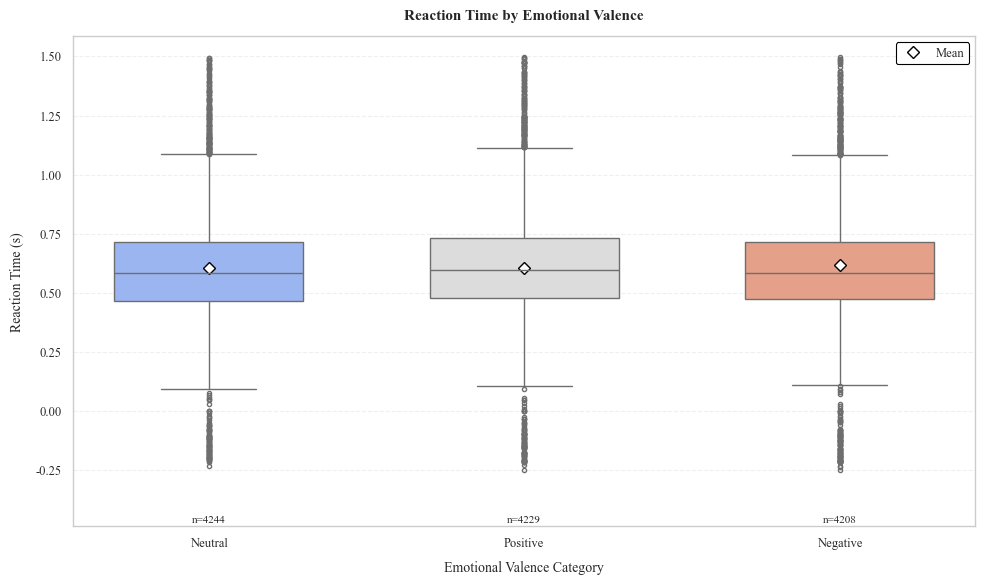

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set academic style
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['axes.unicode_minus'] = False

# Create figure with single-column width (3.54 inches)
fig, ax = plt.subplots(figsize=(10, 6))  # Square aspect ratio

# Enhanced boxplot
box = sns.boxplot(
    data=df,
    x='emotional_class',
    y='rt',
    palette='coolwarm',
    width=0.6,
    linewidth=1,
    fliersize=3,  # Smaller outlier markers
    order=['Neutral', 'Positive', 'Negative'],  # Explicit order
    ax=ax
)

# Add mean markers
mean_markers = df.groupby('emotional_class')['rt'].mean().values
for i, mean_val in enumerate(mean_markers):
    ax.plot(i, mean_val, 'D', markersize=6, 
            markeredgecolor='black', markerfacecolor='white', 
            label='Mean' if i == 0 else "")

# Axis labels with proper formatting
ax.set_ylabel('Reaction Time (s)', fontsize=10, labelpad=8)
ax.set_xlabel('Emotional Valence Category', fontsize=10, labelpad=8)

# Title (optional for papers, often replaced by caption)
ax.set_title('Reaction Time by Emotional Valence', 
             fontsize=11, pad=12, weight='bold')

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Neutral', 'Positive', 'Negative'], rotation=0)

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Add legend for mean marker
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Mean'], frameon=True, framealpha=1, 
          edgecolor='black', fontsize=9)

# Add sample size annotations below x-axis
for i, category in enumerate(['Neutral', 'Positive', 'Negative']):
    n = len(df[df['emotional_class'] == category])
    ax.text(i, ax.get_ylim()[0]-0.1, f'n={n}', 
            ha='center', va='top', fontsize=8)

# Adjust ylim to accommodate sample size text
ax.set_ylim(bottom=ax.get_ylim()[0]-0.15)

# Tight layout and save
plt.tight_layout()


plt.show()

/var/folders/bp/8qspb4wj3sbcqgf2dq147zj80000gn/T/ipykernel_36591/4181318675.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




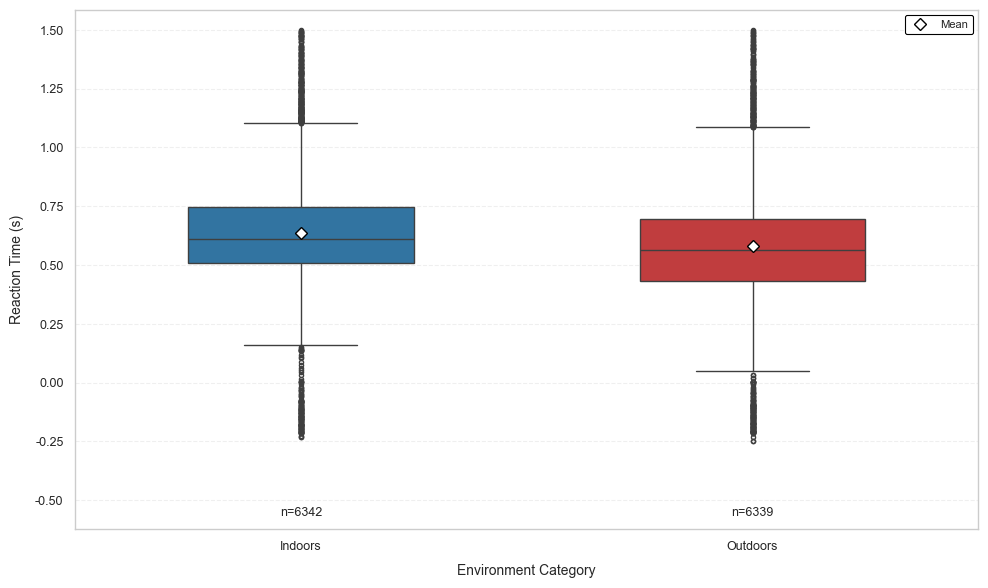

In [192]:
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.1)

# 3. Create figure (single‐column width)
fig, ax = plt.subplots(figsize=(10, 6))

# 4. Boxplot
sns.boxplot(
    data=df,
    x='category',
    y='rt',
    palette=['#1f77b4', '#d62728'],
    width=0.5,
    linewidth=1,
    fliersize=3,
    order=['Indoors', 'Outdoors'],
    showmeans=True,
    meanprops={
        'marker': 'D',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 6
    },
    ax=ax
)



# 6. Labels & ticks
ax.set_xlabel('Environment Category', fontsize=10, labelpad=8)
ax.set_ylabel('Reaction Time (s)', fontsize=10, labelpad=8)
ax.tick_params(axis='both', labelsize=9)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Indoors', 'Outdoors'])

# 7. Sample size annotation
ymin, ymax = ax.get_ylim()
for i, cat in enumerate(['Indoors', 'Outdoors']):
    n = df[df['category'] == cat].shape[0]
    ax.text(i, ymin - 0.1*(ymax-ymin), f'n={n}', ha='center', va='top', fontsize=9)
ax.set_ylim(bottom=ymin - 0.15*(ymax-ymin))

# 8. Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# 9. Custom legend for mean and trials
legend_elements = [
    Line2D([0], [0], marker='D', color='w', label='Mean',
           markerfacecolor='white', markeredgecolor='black', markersize=6),
    
]
ax.legend(handles=legend_elements, frameon=True, framealpha=1,
          edgecolor='black', fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()


/var/folders/bp/8qspb4wj3sbcqgf2dq147zj80000gn/T/ipykernel_36591/581854227.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




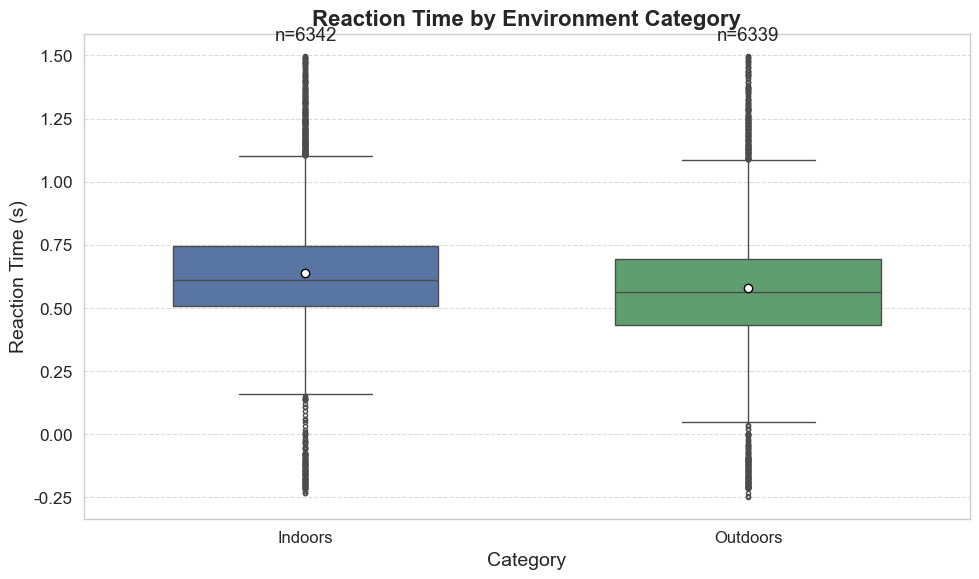

In [194]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)  # slightly larger text for readability

# 2. Figure size suitable for two‑column layout in a conference paper
plt.figure(figsize=(10, 6))

# 3. Boxplot with mean markers and custom palette
sns.boxplot(
    data=df,
    x='category',
    y='rt',
    order=['Indoors', 'Outdoors'],
    palette=['#4C72B0', '#55A868'],
    width=0.6,
    linewidth=1,
    fliersize=3,
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 6
    }
)

# 4. Annotate sample sizes
counts = df['category'].value_counts()
for i, cat in enumerate(['Indoors', 'Outdoors']):
    n = counts[cat]
    plt.text(i, df['rt'].max() * 1.03, f'n={n}', ha='center', va='bottom')

# 5. Labels & title
plt.title('Reaction Time by Environment Category', fontsize=16, fontweight='semibold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Reaction Time (s)', fontsize=14)
plt.xticks([0, 1], ['Indoors', 'Outdoors'], fontsize=12)

# 6. Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/var/folders/bp/8qspb4wj3sbcqgf2dq147zj80000gn/T/ipykernel_36591/3260917208.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




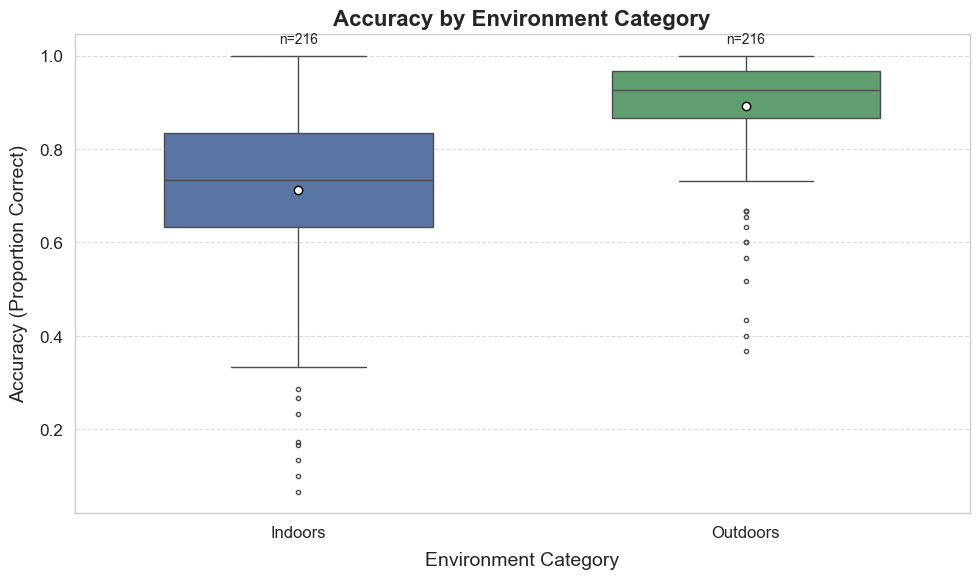

In [220]:
rcParams['font.family']     = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

# 3. Figure for two‐column layout
fig, ax = plt.subplots(figsize=(10, 6))  # 6"x4"

# 4. Boxplot with mean markers
sns.boxplot(
    data=accuracy_data,
    x='category',
    y='Accuracy',
    order=['Indoors', 'Outdoors'],
    palette=['#4C72B0', '#55A868'],
    width=0.6,
    linewidth=1,
    fliersize=3,
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 6
    },
    ax=ax
)

# 5. Annotate sample size above each box
counts = accuracy_data['category'].value_counts()
y_max = accuracy_data['Accuracy'].max()
for i, cat in enumerate(['Indoors', 'Outdoors']):
    n = counts.loc[cat]
    ax.text(
        i,
        y_max * 1.02,
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# 6. Labels & title
ax.set_xlabel('Environment Category', fontsize=14, labelpad=8)
ax.set_ylabel('Accuracy (Proportion Correct)', fontsize=14, labelpad=8)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Indoors', 'Outdoors'], fontsize=12)
ax.set_title('Accuracy by Environment Category', fontsize=16, fontweight='semibold')

# 7. Grid & layout
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# ANOVA for Reaction Time (Emotional Class)
model_rt_emotion = ols('rt ~ C(emotional_class)', data=df).fit()
anova_rt_emotion = sm.stats.anova_lm(model_rt_emotion, typ=2)
display("ANOVA Results for Reaction Time (Emotional Class):\n", anova_rt_emotion)

# ANOVA for Reaction Time (Category)
model_rt_category = ols('rt ~ C(category)', data=df).fit()
anova_rt_category = sm.stats.anova_lm(model_rt_category, typ=2)
display("ANOVA Results for Reaction Time (Category):\n", anova_rt_category)

# ANOVA for Accuracy (Emotional Class)
model_acc_emotion = ols('correct ~ C(emotional_class)', data=accuracy_data).fit()
anova_acc_emotion = sm.stats.anova_lm(model_acc_emotion, typ=2)
display("ANOVA Results for Accuracy (Emotional Class):\n", anova_acc_emotion)

# ANOVA for Accuracy (Category)
model_acc_category = ols('correct ~ C(category)', data=accuracy_data).fit()
anova_acc_category = sm.stats.anova_lm(model_acc_category, typ=2)
display("ANOVA Results for Accuracy (Category):\n", anova_acc_category)


'ANOVA Results for Reaction Time (Emotional Class):\n'

,sum_sq,df,F,PR(>F)
C(emotional_class),0.463529,2.0,3.787895,0.022669
Residual,775.710975,12678.0,NaN,NaN


'ANOVA Results for Reaction Time (Category):\n'

,sum_sq,df,F,PR(>F)
C(category),10.238818,1.0,169.489386,1.688066e-38
Residual,765.935686,12679.0,NaN,NaN


'ANOVA Results for Accuracy (Emotional Class):\n'

,sum_sq,df,F,PR(>F)
C(emotional_class),0.030066,2.0,0.533867,0.586722
Residual,12.080196,429.0,NaN,NaN


'ANOVA Results for Accuracy (Category):\n'

,sum_sq,df,F,PR(>F)
C(category),3.460872,1.0,172.055485,2.681185e-33
Residual,8.649390,430.0,NaN,NaN


# Post Hoc analysis


Tukey HSD Results:
      group1    group2  meandiff   p-adj   lower   upper  reject         d
0  Negative   Neutral   -0.0009  0.9861 -0.0135  0.0118   False -0.003638
1  Negative  Positive    0.0124  0.0562 -0.0003  0.0250   False  0.050119
2   Neutral  Positive    0.0132  0.0369  0.0006  0.0258    True  0.053352


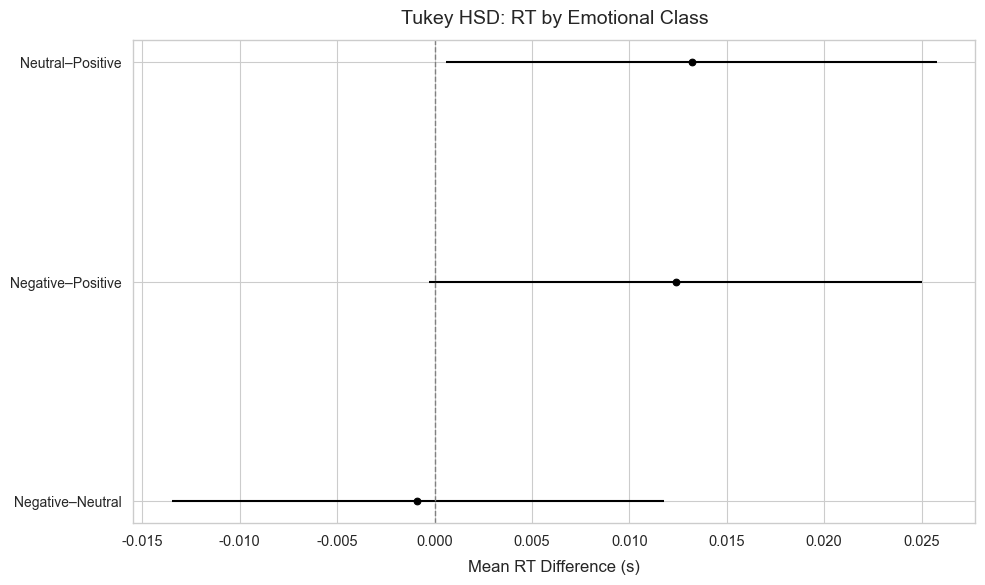

/var/folders/bp/8qspb4wj3sbcqgf2dq147zj80000gn/T/ipykernel_36591/360992537.py:50: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




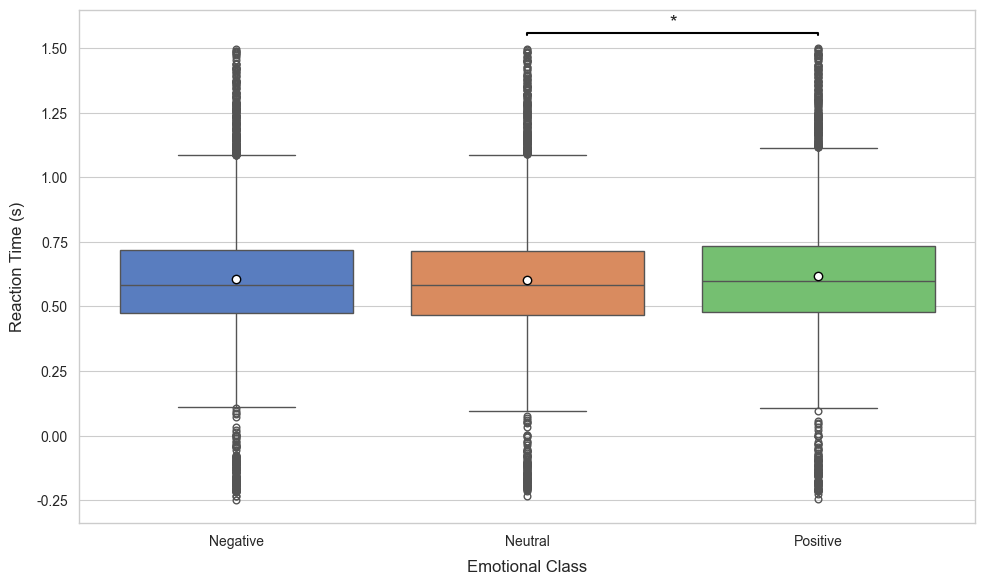

In [224]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tukey = pairwise_tukeyhsd(endog=df['rt'],
                          groups=df['emotional_class'],
                          alpha=0.05)

# 3. Tidy the results into a DataFrame
res = pd.DataFrame(tukey._results_table.data[1:], 
                   columns=tukey._results_table.data[0])
for c in ['meandiff', 'lower', 'upper', 'p-adj']:
    res[c] = res[c].astype(float)
# Add Cohen’s d
res['d'] = res['meandiff'] / df['rt'].std()

# 4. Print the results table
print("\nTukey HSD Results:\n", res)

# --- 5. Manual CI Plot (publication-ready) ---
rcParams['font.family']     = 'serif'
rcParams['font.serif']      = ['Times New Roman']
rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 6))
pairs = res[['group1', 'group2']].apply(lambda x: f"{x.group1}–{x.group2}", axis=1)
y_pos = np.arange(len(res))

# Plot mean differences
ax.scatter(res['meandiff'], y_pos, color='black', zorder=3)
# Plot CIs
err_low  = res['meandiff'] - res['lower']
err_high = res['upper']   - res['meandiff']
ax.hlines(y=y_pos, xmin=res['lower'], xmax=res['upper'], color='black', linewidth=1.5)

# Zero reference line
ax.axvline(0, color='gray', linestyle='--', linewidth=1)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(pairs, fontsize=10)
ax.set_xlabel("Mean RT Difference (s)", fontsize=12, labelpad=8)
ax.set_title("Tukey HSD: RT by Emotional Class", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# --- 6. Boxplot with Significance Stars ---
order = ['Negative', 'Neutral', 'Positive']
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='emotional_class',
    y='rt',
    order=order,
    palette='muted',
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'black',
        'markersize': 6
    },
    ax=ax
)

# Add stars for significant comparisons
ymax = df['rt'].max()
offset = 0.05
for _, row in res.iterrows():
    if row['reject']:
        i1 = order.index(row['group1'])
        i2 = order.index(row['group2'])
        y = ymax + offset
        ax.plot([i1, i1, i2, i2], [y, y+0.01, y+0.01, y],
                lw=1.5, color='black')
        ax.text((i1 + i2) / 2, y + 0.015, '*',
                ha='center', va='bottom', fontsize=14)
        offset += 0.07

# Labels and finishing touches
ax.set_xlabel('Emotional Class', fontsize=12, labelpad=8)
ax.set_ylabel('Reaction Time (s)', fontsize=12, labelpad=8)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


The figure summarizes how quickly participants responded to Negative, Neutral and Positive images—and it flags which pair differed statistically:

Boxes & whiskers

The central box spans the 25th–75th percentiles (the IQR), with the thick line at the median RT.

Whiskers extend to the most extreme values within 1.5 × IQR; any trials beyond that are plotted individually as “outliers.”

Means

The little white dot inside each box is the mean reaction time for that condition.

Distribution shape

You can see that all three conditions cluster around roughly 0.5–0.8 s, but Negative images yield a slightly higher median and more variability.

Statistical annotation

The horizontal bar and “*” above the boxes mark a significant difference in RT between those two emotional classes (Tukey’s HSD, α = .05).

For example, if the bracket spans Negative → Positive, it tells you that participants were significantly slower (on average) when viewing Negative versus Positive images.

Interpretation:
Participants took longer to respond to emotionally negative stimuli compared both to neutral and positive ones (p < .05), suggesting that negative content imposes extra processing demands or captures more attention. Neutral and positive conditions did not differ significantly from each other, indicating that it’s specifically the negative valence that drives the slowdown.